In [1]:
import collections.abc
import sys
from functools import partial

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import HTML

from openretina.hoefling_2024.nnfabrik_model_loading import (
    load_ensemble_retina_model_from_directory,
)
from openretina.neuron_data_io import NeuronGroupMembersStore
from openretina.optimization.objective import SingleNeuronObjective
from openretina.optimization.optimizer import optimize_stimulus
from openretina.optimization.regularizer import (
    ChangeNormJointlyClipRangeSeparately,
    range_regularizer_fn,
)
from openretina.plotting import plot_stimulus_composition

# To avoid import errors in DataJoint
if sys.version_info.major == 3 and sys.version_info.minor >= 3:
    # Python 3.3 and later
    collections.MutableMapping = collections.abc.MutableMapping
    collections.Mapping = collections.abc.Mapping
    collections.Iterable = collections.abc.Iterable
else:
    # Python 3.2 or earlier
    collections.MutableMapping = collections.MutableMapping
    collections.Mapping = collections.Mapping
    collections.Iterable = collections.Iterable

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
neuron_store_path = "/gpfs01/berens/data/data/optimalChirp/neuronStore/ventral_big_with_confidence_and_variance.pkl"
model_dir = "/gpfs01/berens/data/data/optimalChirp/rawModels/bigVentral"
# Overwrite these as above folders aren't mounted in Thomas' current docker container
neuron_store_path = "/gpfs01/euler/User/tzenkel/data/neuronStore/ventral_big_with_confidence_and_variance.pkl"
model_dir = "/gpfs01/euler/User/tzenkel/data/bigVentral"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
neuron_group_member_store = NeuronGroupMembersStore.load_from_file(neuron_store_path)
# Disclaimer: When loading the retina model here from above paths,
# it dynamically loads the code from nnfabrik_euler and not from this repository
data_info, ensemble_model = load_ensemble_retina_model_from_directory(
    model_dir,
    device=device,
)

/gpfs01/euler/User/tzenkel/GitRepos/nnfabrik_euler/nnfabrik_euler/models/batch_correction_cores.py:417: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  mask = mask_tf(time.T, stretches, T)
/.pyenv/versions/miniconda3-latest/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
stimulus_shape = (1, 2, 50, 18, 16)

# pick a random session and neuron
session_id = list(ensemble_model.members[0].readout.keys())[0]
neuron_id = 42

In [5]:
objective = SingleNeuronObjective(ensemble_model, neuron_idx=neuron_id, data_key=session_id)
stimulus = torch.randn(stimulus_shape, requires_grad=True, device=device)
stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately()
stimulus.data = stimulus_postprocessor.process(stimulus.data)
optimizer_init_fn = partial(torch.optim.SGD, lr=10.0)
stimulus_regularizing_fn = partial(
    range_regularizer_fn,
)

In [6]:
optimize_stimulus(
    stimulus,
    optimizer_init_fn,
    objective,
    stimulus_regularizing_fn=stimulus_regularizing_fn,
    postprocess_stimulus_fn=stimulus_postprocessor.process,
    max_iterations=100,
)

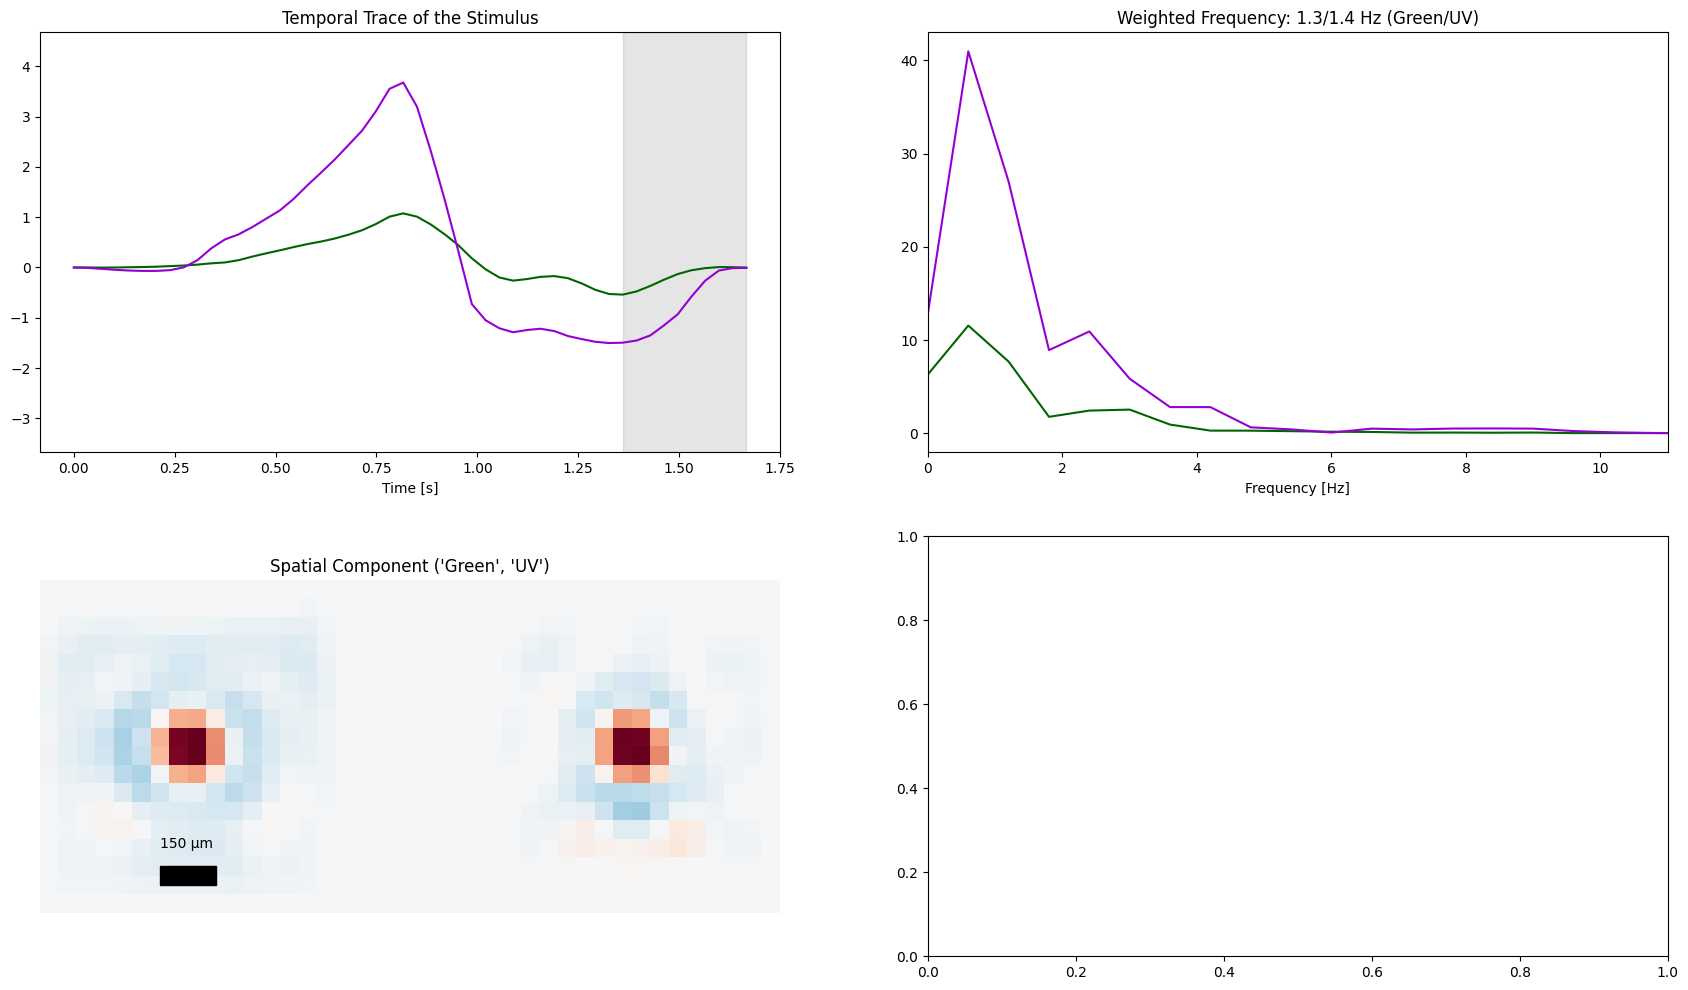

In [7]:
stimulus_np = stimulus[0].cpu().numpy()
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=stimulus_np,
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)